In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from scipy.interpolate import interp1d

%matplotlib ipympl

def generate_clustered_network(N, M, lambda_edges = 2.5, lambda_cliques = 2.0):
    """
    Generates a random clustered network with cliques of size M and removes isolated cliques and nodes.
    
    Parameters:
        N (int): Total number of nodes in the network.
        M (int): Size of the cliques to be formed (M >= 3).
        lambda_edges (float): Average number of single edges per node
        lambda_cliques (float): Average number of cliques per node
    
    Returns:
        adj_matrix (numpy.ndarray): Adjacency matrix of the generated network.
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    random.seed(42)

    # Generate degrees for edges and cliques
    # For simplicity, we assume independence between edges and cliques
    edge_degrees = np.random.poisson(lambda_edges, N)
    clique_degrees = np.random.poisson(lambda_cliques, N)
    
    # Adjust degrees to ensure total stubs are compatible
    # For edges
    if sum(edge_degrees) % 2 != 0:
        idx = np.random.randint(0, N)
        edge_degrees[idx] += 1
    
    # For cliques
    remainder = sum(clique_degrees) % M
    if remainder != 0:
        for _ in range(M - remainder):
            idx = np.random.randint(0, N)
            clique_degrees[idx] += 1
    
    # Create edge stubs and clique stubs
    edge_stubs = []
    for node, degree in enumerate(edge_degrees):
        edge_stubs.extend([node] * degree)
    
    clique_stubs = []
    for node, degree in enumerate(clique_degrees):
        clique_stubs.extend([node] * degree)
    
    # Shuffle stubs
    np.random.shuffle(edge_stubs)
    np.random.shuffle(clique_stubs)
    
    # Construct edges by pairing edge stubs
    edges = []
    for i in range(0, len(edge_stubs), 2):
        if i+1 < len(edge_stubs):
            n1 = edge_stubs[i]
            n2 = edge_stubs[i+1]
            if n1 != n2:
                edges.append((n1, n2))
    
    # Construct cliques by grouping clique stubs into groups of size M
    cliques = []
    for i in range(0, len(clique_stubs), M):
        if i + M - 1 < len(clique_stubs):
            nodes = clique_stubs[i:i+M]
            unique_nodes = set(nodes)
            if len(unique_nodes) == M:
                cliques.append(nodes)
    
    # Combine edges and cliques into adjacency list
    adjacency = {i: set() for i in range(N)}
    
    # Add edges to adjacency list
    for n1, n2 in edges:
        adjacency[n1].add(n2)
        adjacency[n2].add(n1)
    
    # Add cliques to adjacency list
    for clique_nodes in cliques:
        for n1 in clique_nodes:
            others = set(clique_nodes) - {n1}
            adjacency[n1].update(others)
    
    # Remove isolated cliques (loops)
    # Identify connected components
    def dfs(node, visited, component):
        visited.add(node)
        component.add(node)
        for neighbor in adjacency[node]:
            if neighbor not in visited:
                dfs(neighbor, visited, component)
    
    visited = set()
    components = []
    for node in adjacency:
        if node not in visited and adjacency[node]:
            component = set()
            dfs(node, visited, component)
            components.append(component)
    
    # Remove components that are isolated cliques
    nodes_to_remove = set()
    for component in components:
        # Check if the component forms a clique
        is_clique = True
        size = len(component)
        for node in component:
            neighbors = adjacency[node]
            if len(neighbors) != size - 1:
                is_clique = False
                break
        if is_clique:
            nodes_to_remove.update(component)
    
    # Remove nodes of isolated cliques from adjacency
    for node in nodes_to_remove:
        del adjacency[node]
    
    # Also remove references to these nodes from other nodes' adjacency lists
    for node in adjacency:
        adjacency[node] -= nodes_to_remove
    
    # Remove isolated nodes (nodes with no neighbors)
    isolated_nodes = [node for node, neighbors in adjacency.items() if not neighbors]
    for node in isolated_nodes:
        del adjacency[node]
    
    # Reindex nodes to have consecutive indices starting from 0
    remaining_nodes = sorted(adjacency.keys())
    node_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(remaining_nodes)}
    num_nodes = len(remaining_nodes)
    
    # Create adjacency matrix
    adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for old_node, neighbors in adjacency.items():
        new_node = node_mapping[old_node]
        for neighbor in neighbors:
            adj_matrix[new_node, node_mapping[neighbor]] = 1
            # For undirected graph, ensure symmetry
            adj_matrix[node_mapping[neighbor], new_node] = 1
    
    return adj_matrix

def perform_bond_percolation(adj_matrix, N_p, p_values):
    """
    Performs bond percolation on a network defined by adj_matrix over a range of edge retention probabilities.
    
    Parameters:
        adj_matrix (numpy.ndarray): Adjacency matrix of the network.
        N_p (int): Number of percolation trials per edge retention probability.
        p_values (numpy.ndarray): Array of edge retention probabilities (between 0 and 1).
    
    Returns:
        percolation_results (dict): Dictionary containing percolation analysis results.
    """
    num_nodes = adj_matrix.shape[0]
    percolation_results = {
        'p_values': p_values,
        'giant_component_sizes': [],
        'cluster_size_distributions': [],
    }
    
    for p in tqdm(p_values, desc='Percolation Progress'):
        largest_components = []
        cluster_sizes = []
        
        for _ in range(N_p):
            # Perform bond percolation by retaining edges with probability p
            percolated_adj = adj_matrix.copy()
            # Get indices of the upper triangle (since adj_matrix is symmetric)
            upper_tri_indices = np.triu_indices(num_nodes, k=1)
            edges = np.vstack(upper_tri_indices).T
            existing_edges = edges[percolated_adj[upper_tri_indices] > 0]
            
            # Randomly remove edges
            retain_mask = np.random.rand(len(existing_edges)) < p
            retained_edges = existing_edges[retain_mask]
            
            # Create a new adjacency matrix for the percolated graph
            percolated_adj = np.zeros_like(adj_matrix)
            percolated_adj[retained_edges[:, 0], retained_edges[:, 1]] = 1
            percolated_adj[retained_edges[:, 1], retained_edges[:, 0]] = 1  # Symmetric
            
            # Create a NetworkX graph from the percolated adjacency matrix
            G_perc = nx.from_numpy_array(percolated_adj)
            
            # Get connected components
            connected_components = [len(cc) for cc in nx.connected_components(G_perc)]
            
            if connected_components:
                # Largest connected component size
                largest_components.append(max(connected_components) / num_nodes)
                # Record all cluster sizes
                cluster_sizes.extend(connected_components)
            else:
                largest_components.append(0)
        
        # Average size of the largest connected component for this p
        avg_largest_component = np.mean(largest_components)
        percolation_results['giant_component_sizes'].append(avg_largest_component)
        percolation_results['cluster_size_distributions'].append(cluster_sizes)
    
    # Convert lists to numpy arrays
    percolation_results['giant_component_sizes'] = np.array(percolation_results['giant_component_sizes'])
    
    # Estimate the percolation threshold
    percolation_threshold = estimate_percolation_threshold(
        percolation_results['p_values'],
        percolation_results['giant_component_sizes']
    )
    percolation_results['percolation_threshold'] = percolation_threshold
    
    return percolation_results

def estimate_percolation_threshold(p_values, giant_component_sizes):
    """
    Estimates the percolation threshold as the point where the size of the giant component
    increases rapidly (inflection point).
    
    Parameters:
        p_values (numpy.ndarray): Array of edge retention probabilities.
        giant_component_sizes (numpy.ndarray): Corresponding sizes of the largest connected component.
    
    Returns:
        p_c (float): Estimated percolation threshold.
    """
    # Smooth the giant component sizes
    f = interp1d(p_values, giant_component_sizes, kind='cubic')
    p_smooth = np.linspace(p_values[0], p_values[-1], 500)
    gc_smooth = f(p_smooth)
    
    # Compute the derivative of the giant component sizes
    derivative = np.gradient(gc_smooth, p_smooth)
    
    # Find the p value where the derivative is maximized
    max_derivative_index = np.argmax(derivative)
    p_c = p_smooth[max_derivative_index]
    
    return p_c


Processing lambda_cliques = 0.00
Processing lambda_cliques = 0.21
Processing lambda_cliques = 0.43
Processing lambda_cliques = 0.64
Processing lambda_cliques = 0.86
Processing lambda_cliques = 1.07
Processing lambda_cliques = 1.29
Processing lambda_cliques = 1.50
Processing lambda_cliques = 1.71
Processing lambda_cliques = 1.93
Processing lambda_cliques = 2.14
Processing lambda_cliques = 2.36
Processing lambda_cliques = 2.57
Processing lambda_cliques = 2.79
Processing lambda_cliques = 3.00


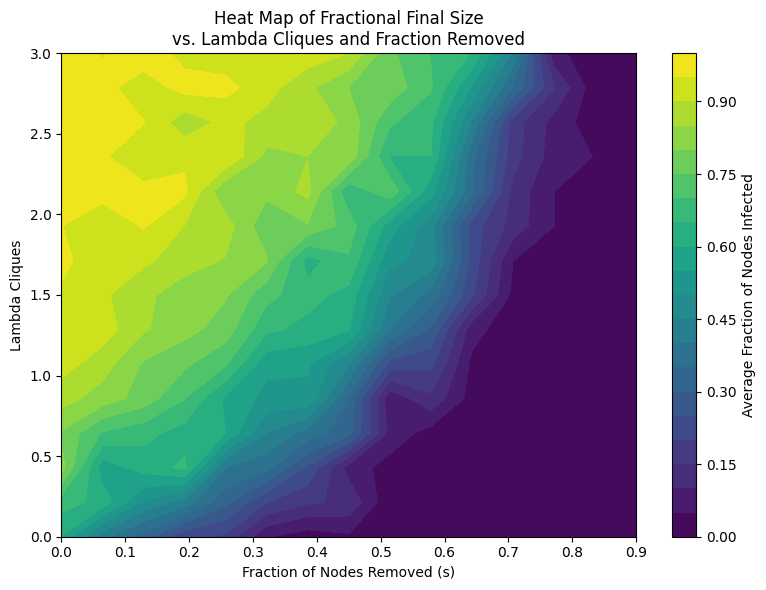

In [32]:
def perform_percolation(adj_matrix, p_i, initial_infected=1):
    """
    Performs percolation starting from randomly selected node(s).

    Parameters:
        adj_matrix (numpy.ndarray): Adjacency matrix of the network.
        p_i (float): Percolation probability (beta / (beta + gamma)).
        initial_infected (int): Number of initial infected nodes.

    Returns:
        fraction_infected (float): Fraction of nodes reached by percolation.
    """
    num_nodes = adj_matrix.shape[0]
    if num_nodes == 0:
        return 0.0  # Empty network

    # Copy the adjacency matrix
    percolated_adj = adj_matrix.copy()

    # Get indices of the upper triangle (since adj_matrix is symmetric)
    upper_tri_indices = np.triu_indices(num_nodes, k=1)
    edges = np.vstack(upper_tri_indices).T
    existing_edges = edges[percolated_adj[upper_tri_indices] > 0]

    # Randomly retain edges with probability p_i
    retain_mask = np.random.rand(len(existing_edges)) < p_i
    retained_edges = existing_edges[retain_mask]

    # Create a new adjacency matrix for the percolated graph
    percolated_adj = np.zeros_like(adj_matrix)
    percolated_adj[retained_edges[:, 0], retained_edges[:, 1]] = 1
    percolated_adj[retained_edges[:, 1], retained_edges[:, 0]] = 1  # Symmetric

    # Create a NetworkX graph from the percolated adjacency matrix
    G_perc = nx.from_numpy_array(percolated_adj)

    # Select initial infected nodes
    nodes = list(G_perc.nodes())
    if not nodes:
        return 0.0  # Empty graph after percolation

    initial_nodes = random.sample(nodes, min(initial_infected, len(nodes)))

    # Perform BFS from initial nodes to find reachable nodes
    infected_nodes = set()
    for initial_node in initial_nodes:
        infected_nodes.update(nx.node_connected_component(G_perc, initial_node))

    fraction_infected = len(infected_nodes) / num_nodes

    return fraction_infected

N = 1000        # Total number of nodes in the network
M = 3          # Size of the cliques
N_runs = 50     # Number of percolation simulations per combination

beta = 0.2      # Infection probability per contact per time step
gamma = 0.1     # Recovery probability per infected node per time step
p_i = beta / (beta + gamma)  # Percolation probability

# Range of lambda_cliques and s values
lambda_cliques_list = np.linspace(0.0, 3.0, 15)  # From 0 to 3 in 7 steps
s_list = np.linspace(0.0, 0.9, 15)              # From 0 to 0.9 in 10 steps

# Prepare a matrix to store average final sizes
average_final_sizes = np.zeros((len(lambda_cliques_list), len(s_list)))

for i, lambda_cliques in enumerate(lambda_cliques_list):
    print(f"Processing lambda_cliques = {lambda_cliques:.2f}")
    # Generate the network
    adj_matrix_full = generate_clustered_network(N, M, lambda_cliques=lambda_cliques)

    for j, s in enumerate(s_list):
        # Remove a fraction s of nodes uniformly
        num_nodes_full = adj_matrix_full.shape[0]
        num_nodes_to_remove = int(s * num_nodes_full)
        nodes_to_remove = random.sample(range(num_nodes_full), num_nodes_to_remove)
        nodes_to_keep = np.setdiff1d(np.arange(num_nodes_full), nodes_to_remove)

        # Create the reduced adjacency matrix
        adj_matrix_reduced = adj_matrix_full[np.ix_(nodes_to_keep, nodes_to_keep)]

        # If the network is empty, skip the simulation
        if adj_matrix_reduced.size == 0 or adj_matrix_reduced.shape[0] == 0:
            average_final_sizes[i, j] = 0
            continue

        fractions_infected = []
        for _ in range(N_runs):
            # Perform percolation
            fraction_infected = perform_percolation(adj_matrix_reduced, p_i)
            fractions_infected.append(fraction_infected)
        # Compute average fraction infected
        average_final_sizes[i, j] = np.mean(fractions_infected)

# Create the heat map
s_grid, lambda_cliques_grid = np.meshgrid(s_list, lambda_cliques_list)

plt.figure(figsize=(8, 6))
plt.contourf(s_grid, lambda_cliques_grid, average_final_sizes, levels=20, cmap='viridis')
plt.colorbar(label='Average Fraction of Nodes Infected')
plt.xlabel('Fraction of Nodes Removed (s)')
plt.ylabel('Lambda Cliques')
plt.title('Heat Map of Fractional Final Size\nvs. Lambda Cliques and Fraction Removed')
plt.tight_layout()
plt.show()


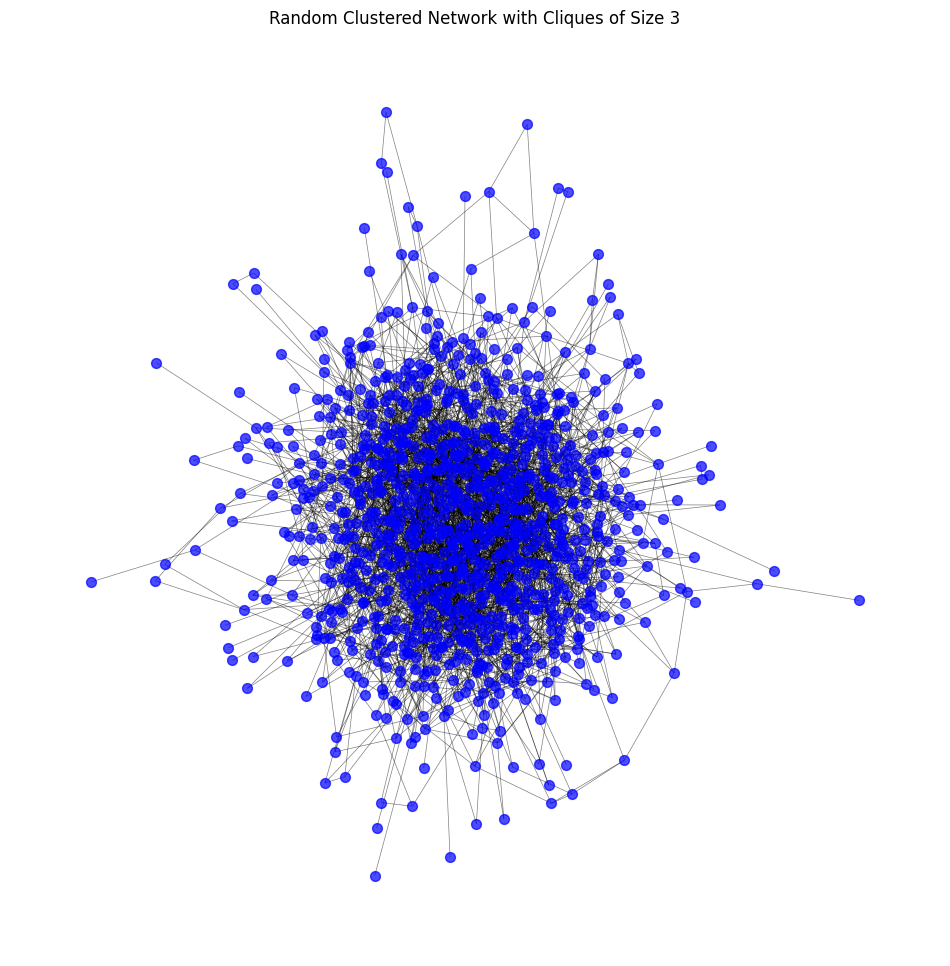

In [2]:
N = 1000   # Number of nodes in the network
M = 3     # Size of the cliques

# Generate the adjacency matrix
adj_matrix = generate_clustered_network(N, M)

# Create a NetworkX graph for visualization
G = nx.from_numpy_array(adj_matrix)

# Draw the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, iterations=100)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue', alpha=0.7)

# Draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)

plt.axis('off')
plt.title(f'Random Clustered Network with Cliques of Size {M}')
plt.show()

Percolation Progress: 100%|██████████| 101/101 [01:06<00:00,  1.52it/s]


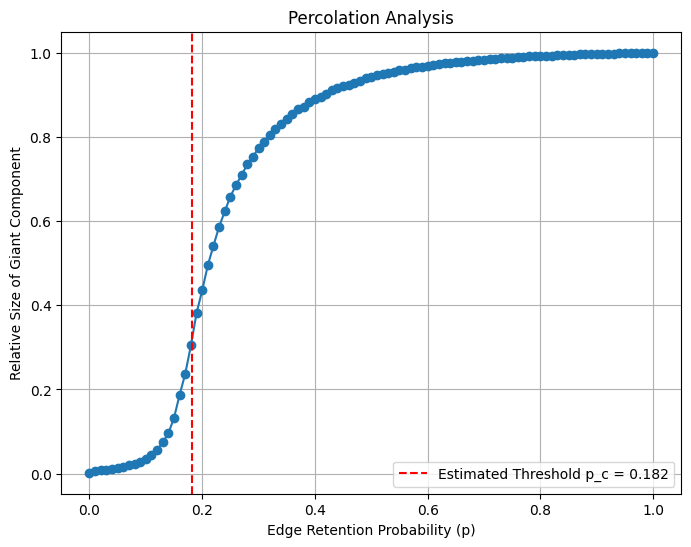

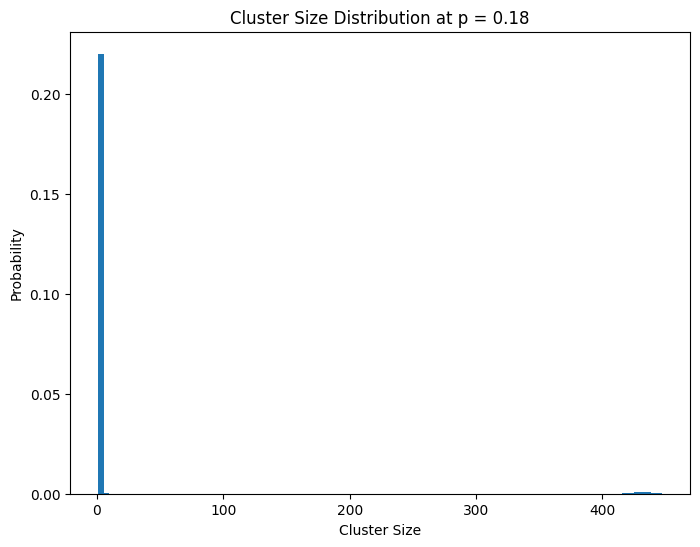

In [4]:
# Assume adj_matrix is obtained from the previous function generate_clustered_network
N = 500
M = 3
adj_matrix = generate_clustered_network(N, M)

# Define percolation parameters
N_p = 200  # Number of trials per p
p_values = np.linspace(0.0, 1.0, 101)  # Edge retention probabilities from 0 to 1

# Perform bond percolation
percolation_results = perform_bond_percolation(adj_matrix, N_p, p_values)

# Plot the size of the giant component vs. p
plt.figure(figsize=(8, 6))
plt.plot(percolation_results['p_values'], percolation_results['giant_component_sizes'], marker='o')
plt.axvline(percolation_results['percolation_threshold'], color='r', linestyle='--', label=f'Estimated Threshold p_c = {percolation_results["percolation_threshold"]:.3f}')
plt.title('Percolation Analysis')
plt.xlabel('Edge Retention Probability (p)')
plt.ylabel('Relative Size of Giant Component')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, plot the cluster size distribution at the percolation threshold
p_c_index = np.argmin(np.abs(percolation_results['p_values'] - percolation_results['percolation_threshold']))
cluster_sizes_at_pc = percolation_results['cluster_size_distributions'][p_c_index+20]

plt.figure(figsize=(8, 6))
plt.hist(cluster_sizes_at_pc, bins = 100, density=True)
plt.title(f'Cluster Size Distribution at p = {percolation_results["p_values"][p_c_index]:.2f}')
plt.xlabel('Cluster Size')
plt.ylabel('Probability')
plt.show()


Percolation Progress: 100%|██████████| 101/101 [01:20<00:00,  1.25it/s]


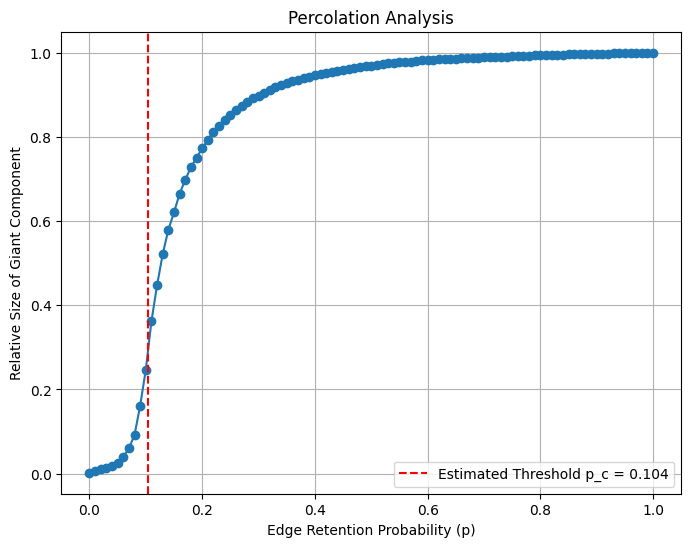

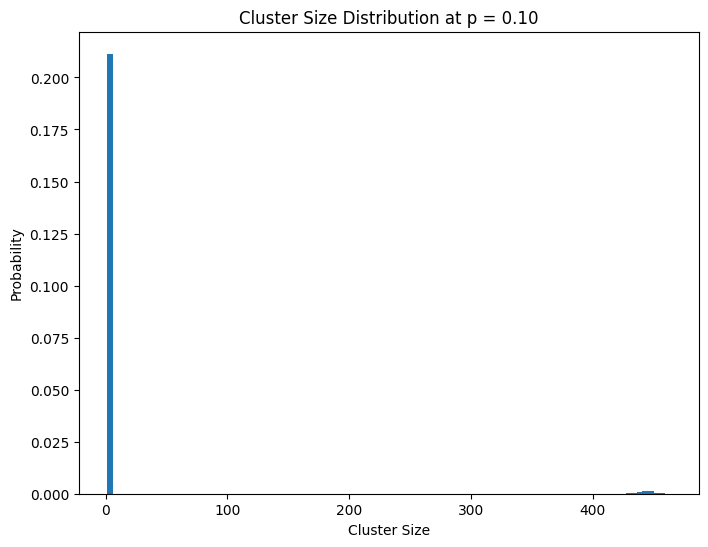

In [5]:
# Assume adj_matrix is obtained from the previous function generate_clustered_network
N = 500
M = 5
adj_matrix = generate_clustered_network(N, M)

# Define percolation parameters
N_p = 200  # Number of trials per p
p_values = np.linspace(0.0, 1.0, 101)  # Edge retention probabilities from 0 to 1

# Perform bond percolation
percolation_results = perform_bond_percolation(adj_matrix, N_p, p_values)

# Plot the size of the giant component vs. p
plt.figure(figsize=(8, 6))
plt.plot(percolation_results['p_values'], percolation_results['giant_component_sizes'], marker='o')
plt.axvline(percolation_results['percolation_threshold'], color='r', linestyle='--', label=f'Estimated Threshold p_c = {percolation_results["percolation_threshold"]:.3f}')
plt.title('Percolation Analysis')
plt.xlabel('Edge Retention Probability (p)')
plt.ylabel('Relative Size of Giant Component')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, plot the cluster size distribution at the percolation threshold
p_c_index = np.argmin(np.abs(percolation_results['p_values'] - percolation_results['percolation_threshold']))
cluster_sizes_at_pc = percolation_results['cluster_size_distributions'][p_c_index+20]

plt.figure(figsize=(8, 6))
plt.hist(cluster_sizes_at_pc, bins = 100, density=True)
plt.title(f'Cluster Size Distribution at p = {percolation_results["p_values"][p_c_index]:.2f}')
plt.xlabel('Cluster Size')
plt.ylabel('Probability')
plt.show()

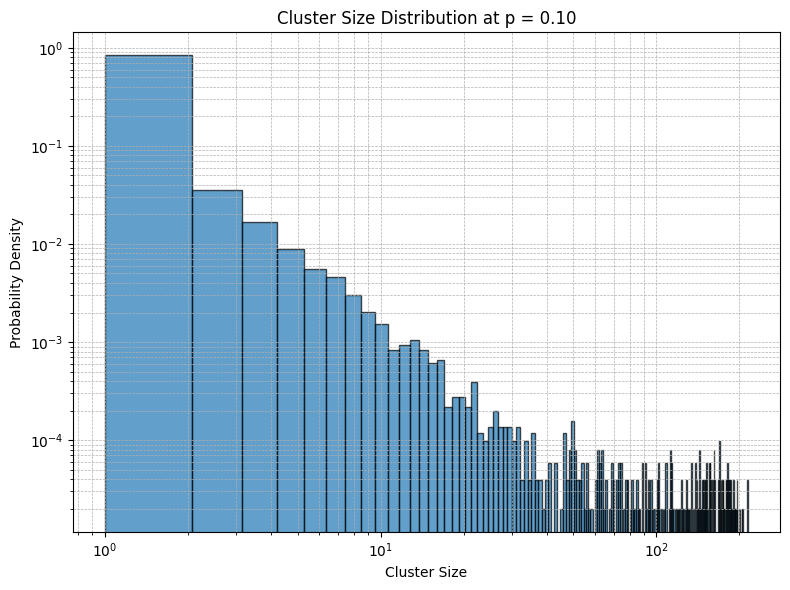

In [6]:
# Get the cluster sizes at the percolation threshold
p_c_index = np.argmin(np.abs(percolation_results['p_values'] - percolation_results['percolation_threshold']))
cluster_sizes_at_pc = percolation_results['cluster_size_distributions'][p_c_index]

# Remove clusters of size zero (if any)
cluster_sizes = [size for size in cluster_sizes_at_pc if size > 0]

# Create logarithmically spaced bins for the histogram
min_cluster_size = min(cluster_sizes)
max_cluster_size = max(cluster_sizes)
#bins = np.logspace(np.log10(min_cluster_size), np.log10(max_cluster_size), num=50)

# Plot the histogram on a log-log scale
plt.figure(figsize=(8, 6))
plt.hist(cluster_sizes, bins=200, density=True, log=True, edgecolor='black', alpha=0.7)

# Set the scales to logarithmic
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel('Cluster Size')
plt.ylabel('Probability Density')
plt.title(f'Cluster Size Distribution at p = {percolation_results["p_values"][p_c_index]:.2f}')

# Grid and layout adjustments
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


# What to ask now
- Can we produce the same analytical results as in Miller and Newman papers?
- How do we conduct the vaccination scheme (so how does clustering change outbreak prop - what fraction are in large cluster sizes/outbraks)?
    - This could involve picking uniformly to clusters in some way, and vaccinating/not vaccinating whole cliques, effectivly removing them from the graph
- As the mean number of M-cliques pr. nodes changes, how does the percolation parameter do so?
- Uniformly remove s nodes, vary "cliqueness" and record average outbreaksize.